This notebook is used to perform basic EDA on the CBECS dataset.

In [160]:
# Import packages
import pandas as pd
import pathlib
import yaml
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

Now we'll read in data from both 2018 and 2012

In [161]:
import pathlib
import yaml

# Get the current working directory
notebook_dir = pathlib.Path().resolve()

# Move up one directory to reach the project root (CBECS_portfolio)
config_path = notebook_dir.parent / 'conf' / 'config.yaml'

# Load the config file
CFG = yaml.safe_load(open(config_path))

# Get the raw data directory from the config and adjust path to project root
RAW_DIR = notebook_dir.parent / CFG["data"]["raw_dir"]

# Create an empty dictionary to store the dataframes
data_frames = {}

# Loop through each dataset in the config and load the CSVs
for dataset in CFG["datasets"]:
    year = dataset["year"]
    # Construct the file path to the raw data
    raw_file = RAW_DIR / f"cbecs_{year}_microdata.csv"
    
    # Read the CSV file into a DataFrame
    if raw_file.exists():
        data_frames[year] = pd.read_csv(raw_file)
    else:
        print(f"Warning: {raw_file} not found.")


# Merge datasets on all columns which exist in both datasets. Nothing was renamed between years, but some columns were added and dropped.
common_columns = data_frames[2018].columns.intersection(data_frames[2012].columns).tolist()
df = pd.merge(data_frames[2018], data_frames[2012], on=common_columns, how="outer")


Text(0, 0.5, 'Count')

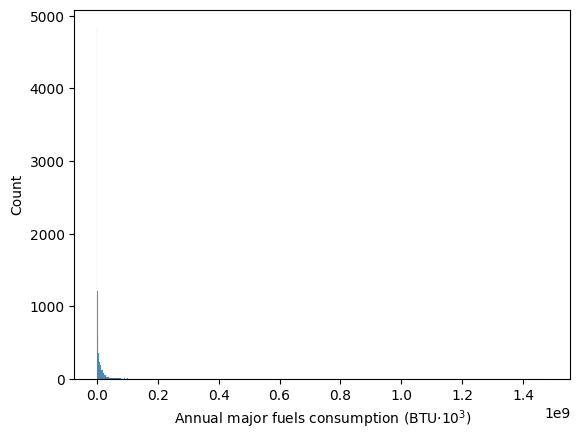

In [162]:
# Drop all instances where the expected target variable isn't reported
df.dropna(subset='MFBTU')
sns.histplot(df["MFBTU"])
plt.xlabel(r"Annual major fuels consumption (BTU$\cdot10^{3}$)")
plt.ylabel("Count")

There are 1524 columns in this dataset. Next step is to trim features that aren't useful.


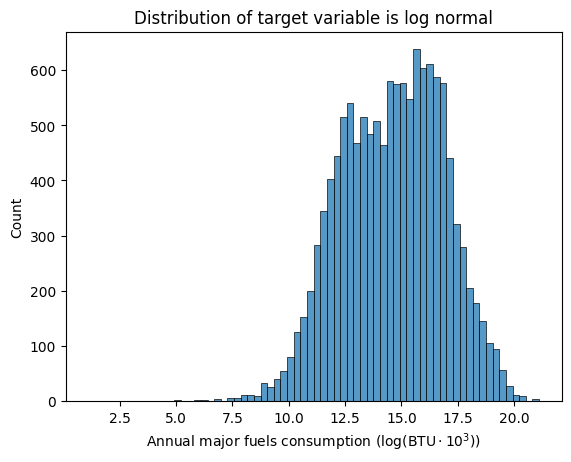

In [163]:
# Clearly the target variable is not normally distributed. Check to see if log-normal.
sns.histplot(np.log(df["MFBTU"]))
plt.xlabel(r"Annual major fuels consumption ($\log(\text{BTU}\cdot10^{3}$))")
plt.ylabel("Count")
plt.title("Distribution of target variable is log normal")
print(f"There are {df.shape[1]} columns in this dataset. Next step is to trim features that aren't useful.")

In [ ]:
# Add log for target
df["LOG_MFBTU"] = np.log(df["MFBTU"])

# First remove all variables where the target variable, LOG_MFBTU is NAN
df = df.dropna(subset="LOG_MFBTU")


# Columns to trim to avoid data leakage
df.describe()

# Prune features that aren't useful...
print(f"number of features before after pruning: {df.shape[1]}")
      
# First we'll remove features that are more than 70% empty
missing_threshold = 0.7
df = df.dropna(thresh=int((1- missing_threshold) * len(df)), axis = 1)

# Check how many features remaining..
print(f"number of features after thresholding for missing information: {df.shape[1]}")

# Lots of features are just imputation flags, which I'm not that concerned with.. those all have values that are only 0, 1, or 9. Remove them.

# Function to return boolean whether column is solely 0,1,9
def is_binary_or_special(column):
    # Get unique values in the columns
    unique_values = column.unique()
    return set(unique_values).issubset({0,1,9})

columns_to_remove = [col for col in df.columns if is_binary_or_special(df[col])]

df = df.drop(columns = columns_to_remove)

print(f"number of features after removing imputation flags: {df.shape[1]}")

# Define columns to go into scikit learn
y = df["LOG_MFBTU"]
X = df.drop(["MFBTU", "LOG_MFBTU"], axis = 1)

# Assume df is your original DataFrame
sel = VarianceThreshold(threshold=0.1)  # Can adjust the threshold for near-constant features

# Apply VarianceThreshold and transform the data
df_transformed = sel.fit_transform(df)

# Get the selected column names based on the original DataFrame's columns
selected_columns = df.columns[sel.get_support()]

# Create a new DataFrame with the selected columns
df = pd.DataFrame(df, columns=selected_columns)

# Check the number of features remaining after pruning
print(f"Number of features after variance pruning: {df.shape[1]}")

# Drop columns that are calculation weights we won't use...
columns_to_drop = df.filter(regex="FINALWT[0-9]{0,3}").columns
df = df.drop(columns_to_drop, axis=1)
print(f"Number of features after dropping weights: {df.shape[1]}")

# Drop rows that will likely cause data leakage with the target variable

rows_to_drop = [
    "MFEXP", "ELBTU", "ELCNS", "ELEXP", "NGBTU", "NGCNS", "NGEXP",
    "MFHTBTU", "MFCLBTU", "MFVNBTU", "MFWTBTU", "MFLTBTU", "MFCKBTU",
    "MFRFBTU", "MFOFBTU", "MFPCBTU", "MFOTBTU", "ELHTBTU", "ELCLBTU",
    "ELVNBTU", "ELWTBTU", "ELLTBTU", "ELCKBTU", "ELRFBTU", "ELOFBTU",
    "ELPCBTU", "ELOTBTU", "NGHTBTU", "NGCLBTU", "NGWTBTU", "NGCKBTU",
    "NGOTBTU", "PUBID"
]

df = df.drop(columns = rows_to_drop, axis=1)


print(f"Number of features after dropping data leakage risks: {df.shape[1]}")


/var/folders/dx/csf989m17lv7mvsqc_xjs7d80000gn/T/ipykernel_87686/551078635.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["LOG_MFBTU"] = np.log(df["MFBTU"])


number of features before after pruning: 1525
number of features after thresholding for missing information: 1140
number of features after removing imputation flags: 1028
Number of features after variance pruning: 843
Number of features after dropping weights: 645
Number of features after dropping data leakage risks: 613


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Define columns to go into scikit learn
y = df["LOG_MFBTU"]
X = df.drop(["MFBTU", "LOG_MFBTU"], axis = 1)

# Fit Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(X, y)  # Assuming X is your feature matrix and y is your target variable


RandomForestRegressor(random_state=42)

     Feature  Importance
5       SQFT    0.769624
18    NELVTR    0.019720
46     WKHRS    0.016122
48     NWKER    0.016010
116   RFGWIN    0.010170
54     HEATP    0.009082
65     COOLP    0.008823
394  ZRFGWIN    0.007768
109    RFGWI    0.007072
473   ZNGCNS    0.004976


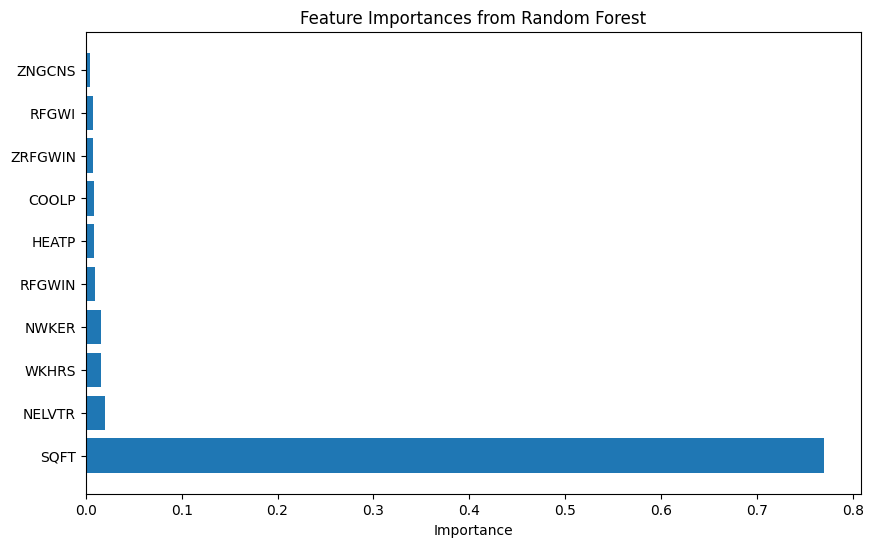

In [176]:
feature_names = X.columns

# Get feature importances
importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    "Importance": importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print(importance_df.head(10))

# Plot the feature importances
plt.figure(figsize=(10, 6))

# Use iloc to select the top 10 features by position
plt.barh(importance_df.iloc[:10]['Feature'], importance_df.iloc[:10]['Importance'])

plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

In [ ]:
# Now let's drop a bunch of poorly performing features and try again...
# Define a threshold for feature importance (e.g., 0.01)
threshold = 0.001

# Select features with importance above the threshold
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature']

# Filter the dataset to keep only the selected features
X_selected = X[selected_features]

print(f"Selected features after applying threshold: {selected_features.tolist()}")

# Fit Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(X_selected, y)  # Assuming X is your feature matrix and y is your target variable

importance_df = pd.DataFrame({
    'Feature': feature_names,
    "Importance": importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print(importance_df.head(10))




Selected features after applying threshold: ['SQFT', 'NELVTR', 'WKHRS', 'NWKER', 'RFGWIN', 'HEATP', 'COOLP', 'ZRFGWIN', 'RFGWI', 'ZNGCNS', 'NGUSED', 'PCTERMN', 'EMCS', 'ZNGEXP', 'HDD65', 'PBAPLUS', 'STRLZR', 'LTNHRP', 'PUBID', 'LTOHRP', 'ZEMCS', 'CDD65', 'NGCOOK', 'PBA', 'OPNMF', 'YRCON', 'ZMFBTU', 'MONUSE', 'DAYLTP', 'FLCEILHT', 'FLUORP', 'LABEQP', 'WKHRSC', 'TVVIDEON', 'NWKERC', 'MAINT', 'SERVERN', 'ZLABEQP', 'LAPTPN']
     Feature  Importance
5       SQFT    0.769624
18    NELVTR    0.019720
46     WKHRS    0.016122
48     NWKER    0.016010
116   RFGWIN    0.010170
54     HEATP    0.009082
65     COOLP    0.008823
394  ZRFGWIN    0.007768
109    RFGWI    0.007072
473   ZNGCNS    0.004976


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected,y, test_size = 0.8, random_state=1)


model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(X,y)



train_score = model.score(X_train, y_train)
print(f"R^2 score on training data: {train_score}")
test_score = model.score(X_test, y_test)
print(f"R^2 score on test data: {test_score}")




ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- ACWNWL
- ACWNWL_EL
- AMIMETER
- ATTIC
- AWN
- ...
